# Casas smarthome ADS Coursework

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import datetime
import os
import re
import seaborn as sns
from collections import Counter
from datetime import datetime



In [3]:
sensor_codes = ['M001', 'M002', 'M003', 'M004', 'M005', 'M006', 'M007', 
                'M008', 'M009', 'M010', 'M011', 'M012', 'M013', 'M014',
                'M015', 'M016', 'M017', 'M018', 'M019', 'M020', 'M021', 
                'M022', 'M023', 'M024', 'M025', 'M026', 'M027', 'M028',
                'M029', 'M030', 'D001', 'D002', 'D003', 'D004', 'T001',
                'T002', 'T003', 'T004', 'T005']

In [4]:
sensor_pos = {
   'M001':1, 'M002':2, 'M003':3, 'M004':4, 'M005':5, 'M006':6, 'M007':7, 
   'M008':8, 'M009':9, 'M010':10, 'M011':11, 'M012':12, 'M013':13, 'M014':14,
    'M015':15, 'M016':16, 'M017':17, 'M018':18, 'M019':19, 'M020':20, 'M021':21, 
    'M022':22, 'M023':23, 'M024':24, 'M025':25, 'M026':26, 'M027':27, 'M028':28,
    'M029':29, 'M030':30, 'D001':31, 'D002':32, 'D003':33, 'D004':34, 'T001':35,
    'T002':36, 'T003':37, 'T004':38, 'T005':39 
}

# Data cleaning

In [5]:
def load_dataset(filename):
    timestamps = []
    sensors = []
    values = []
    activities = []
    current_activity = ''  # empty

    with open(filename, 'rb') as features:
        database = features.readlines()
        
        for i, line in enumerate(database):  # each line
            f_info = line.decode().split()  # find fields
            try:
                if 'M' == f_info[2][0] or 'D' == f_info[2][0] or 'T' == f_info[2][0]:
                    if str(np.array(f_info[2])) in sensor_codes:
                        sensors.append(str(np.array(f_info[2])))
                    else:
                        continue
                       
                    if 'OFF' in f_info[3]:
                        values.append('OFF')
                    elif 'ON' in f_info[3]:
                        values.append('ON')
                    else:
                        try:
                            values.append(float(str(np.array(f_info[3]))))
                        except ValueError:
                            del sensors[-1]
                            continue
                            
                    # choose only M D T sensors, avoiding unexpected errors
                    if not ('.' in str(np.array(f_info[0])) + str(np.array(f_info[1]))):
                        f_info[1] = f_info[1] + '.000000'
                        
                    try:
                        timestamps.append(datetime.strptime(str(np.array(f_info[0])) + str(np.array(f_info[1])),
                                                        "%Y-%m-%d%H:%M:%S.%f"))
                    except ValueError:
                        del sensors[-1]
                        del values[-1]
                        continue
                        
                    if len(f_info) == 4:  # if activity does not exist
                        activities.append(current_activity)
                    else:  # if activity exists
                        des = str(' '.join(np.array(f_info[4:])))
                        if 'begin' in des:
                            current_activity = re.sub('begin', '', des)
                            if current_activity[-1] == ' ':  # if white space at the end
                                current_activity = current_activity[:-1]  # delete white space
                            activities.append(current_activity)
                        if 'end' in des:
                            activities.append(current_activity)
                            current_activity = ''
            except IndexError:
                print(i, line)
                
    features.close()
    
    return pd.DataFrame(np.transpose(np.array([timestamps, sensors, values, activities])), 
                        columns = ['Timestamps', 'Sensors', 'Values', 'Activities'])
    

In [6]:
aruba_dataset = load_dataset("./datasets/aruba/data")

In [7]:
#copy_aruba = aruba_dataset[:5000].copy();
copy_aruba = aruba_dataset.copy();

In [8]:
def add_transition_labels(aruba_set):
    new_activity = ''
    previous_activity = ''
    
    for i, entry in enumerate(aruba_set['Activities']): 
        if entry == '':
            if new_activity != '':
                aruba_set.at[i, 'Activities'] = new_activity
            else:
                for next_entry in aruba_set['Activities'][i:]:
                    if next_entry != '':
                        new_activity = 'Transition_' + previous_activity + '_' + next_entry
                        aruba_set.at[i, 'Activities'] = new_activity
                        break            
        else:
            previous_activity = entry
            new_activity = ''
    return aruba_set

In [9]:
complete_aruba = add_transition_labels(copy_aruba)

In [10]:
complete_aruba.head(10)

,Timestamps,Sensors,Values,Activities
0,2010-11-04 00:03:50.209589,M003,ON,Sleeping
1,2010-11-04 00:03:57.399391,M003,OFF,Sleeping
2,2010-11-04 00:15:08.984841,T002,21.5,Sleeping
3,2010-11-04 00:30:19.185547,T003,21.0,Sleeping
4,2010-11-04 00:30:19.385336,T004,21.0,Sleeping
5,2010-11-04 00:35:22.245870,T005,20.5,Sleeping
6,2010-11-04 00:40:25.428962,T005,21.0,Sleeping
7,2010-11-04 00:45:28.658171,T005,20.5,Sleeping
8,2010-11-04 01:05:42.269469,T001,20.0,Sleeping
9,2010-11-04 01:15:48.936777,T002,21.0,Sleeping


# Pre-processing

In [11]:
def process_time_data(dataset):
    weekday = []
    seconds = []
    daytime = []
    
    for instance in dataset["Timestamps"]:
        weekday.append(instance.day_of_week)
        seconds.append(instance.hour * 3600 + instance.minute * 60 + instance.second)
        if instance.hour >= 0 and instance.hour <= 6:
            daytime.append('Morning_Night')
        elif instance.hour >= 6 and instance.hour <= 12:
            daytime.append('Morning_Day')
        elif instance.hour >= 12 and instance.hour <= 18:
            daytime.append('Afternoon')
        else: 
            daytime.append('Evening')
        
    dataset["Weekday"] = weekday
    dataset["Seconds"] = seconds
    dataset["Daytime"] = daytime
    return dataset


In [12]:
copy_complete_aruba = complete_aruba.copy();

In [13]:
timed_aruba = process_time_data(copy_complete_aruba)

In [14]:
timed_aruba.head()


,Timestamps,Sensors,Values,Activities,Weekday,Seconds,Daytime
0,2010-11-04 00:03:50.209589,M003,ON,Sleeping,3,230,Morning_Night
1,2010-11-04 00:03:57.399391,M003,OFF,Sleeping,3,237,Morning_Night
2,2010-11-04 00:15:08.984841,T002,21.5,Sleeping,3,908,Morning_Night
3,2010-11-04 00:30:19.185547,T003,21.0,Sleeping,3,1819,Morning_Night
4,2010-11-04 00:30:19.385336,T004,21.0,Sleeping,3,1819,Morning_Night


In [15]:
timed_aruba.describe()

,Weekday,Seconds
count,1.709857e+06,1.709857e+06
mean,2.988941e+00,5.017661e+04
std,2.021840e+00,1.894967e+04
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,3.486000e+04
50%,3.000000e+00,5.172100e+04
75%,5.000000e+00,6.566100e+04
max,6.000000e+00,8.639900e+04


In [16]:
data = timed_aruba.drop(columns=['Timestamps'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709857 entries, 0 to 1709856
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Sensors     object
 1   Values      object
 2   Activities  object
 3   Weekday     int64 
 4   Seconds     int64 
 5   Daytime     object
dtypes: int64(2), object(4)
memory usage: 78.3+ MB


In [18]:
sensors_col = data['Sensors'].copy()
values_col = data['Values'].copy()

print(sensors_col[:5])
print(values_col[:5])

0    M003
1    M003
2    T002
3    T003
4    T004
Name: Sensors, dtype: object
0      ON
1     OFF
2    21.5
3    21.0
4    21.0
Name: Values, dtype: object


In [19]:
data2 = data.drop(columns=['Sensors', 'Values'])
data2.head()

,Activities,Weekday,Seconds,Daytime
0,Sleeping,3,230,Morning_Night
1,Sleeping,3,237,Morning_Night
2,Sleeping,3,908,Morning_Night
3,Sleeping,3,1819,Morning_Night
4,Sleeping,3,1819,Morning_Night


In [20]:
temperatures = []
for x in values_col:
    try:
        temperatures.append(float(x))
    except ValueError:
        pass

mean_temp = np.array(temperatures).mean()
print(mean_temp)

23.018337522518657


In [21]:
def init_df_state(sensor_codes, mean_temp):
    state_df = pd.DataFrame()
    for sensor in sensor_codes:
        if sensor[0] == 'T':
            state_df.at[0, sensor] = mean_temp
        else:
            state_df.at[0, sensor] = 0 #OFF
            
    return state_df

In [22]:
state_df = init_df_state(sensor_codes, mean_temp)
state_df

,M001,M002,M003,M004,M005,M006,M007,M008,M009,M010,...,M030,D001,D002,D003,D004,T001,T002,T003,T004,T005
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338


In [23]:
def create_empty_df(current_state, sensors):
    df = pd.DataFrame(columns = current_state.columns, 
                   index = range(len(sensors)))
    return df

In [24]:
empty_df = create_empty_df(state_df, sensors_col)

In [25]:
empty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709857 entries, 0 to 1709856
Data columns (total 39 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   M001    object
 1   M002    object
 2   M003    object
 3   M004    object
 4   M005    object
 5   M006    object
 6   M007    object
 7   M008    object
 8   M009    object
 9   M010    object
 10  M011    object
 11  M012    object
 12  M013    object
 13  M014    object
 14  M015    object
 15  M016    object
 16  M017    object
 17  M018    object
 18  M019    object
 19  M020    object
 20  M021    object
 21  M022    object
 22  M023    object
 23  M024    object
 24  M025    object
 25  M026    object
 26  M027    object
 27  M028    object
 28  M029    object
 29  M030    object
 30  D001    object
 31  D002    object
 32  D003    object
 33  D004    object
 34  T001    object
 35  T002    object
 36  T003    object
 37  T004    object
 38  T005    object
dtypes: object(39)
memory usage: 508.8+ MB


In [26]:
def compute_sensor_state(current_state, sensors, values, new_df):
    row = np.array(current_state.iloc[0])

    for i in range(0, len(sensors)):
        if values[i] == 'ON' or values[i] == 'OPEN':
            row[sensor_pos[sensors[i]]-1] = 1
        elif values[i] == 'OFF' or values[i] == 'CLOSE':
            row[sensor_pos[sensors[i]]-1] = 0
        else:
            row[sensor_pos[sensors[i]]-1] = float(values[i])
    
        new_df.iloc[i] = row
    
    return new_df

In [27]:
state = compute_sensor_state(state_df, sensors_col, values_col, empty_df)

In [28]:
state.iloc[48, :20]

M001    0.0
M002    0.0
M003    0.0
M004    0.0
M005    0.0
M006    0.0
M007    1.0
M008    0.0
M009    0.0
M010    0.0
M011    0.0
M012    0.0
M013    0.0
M014    0.0
M015    0.0
M016    0.0
M017    0.0
M018    0.0
M019    0.0
M020    0.0
Name: 48, dtype: object

In [29]:
state

,M001,M002,M003,M004,M005,M006,M007,M008,M009,M010,...,M030,D001,D002,D003,D004,T001,T002,T003,T004,T005
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.5,23.018338,23.018338,23.018338
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.5,21.0,23.018338,23.018338
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.5,21.0,21.0,23.018338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,25.5,24.5,24.5,23.5
1709853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.5,25.5,24.5,24.5,23.5
1709854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.5,25.0,24.5,24.5,23.5
1709855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.5,25.5,24.5,24.5,23.5


In [30]:
data2.shape
data2

,Activities,Weekday,Seconds,Daytime
0,Sleeping,3,230,Morning_Night
1,Sleeping,3,237,Morning_Night
2,Sleeping,3,908,Morning_Night
3,Sleeping,3,1819,Morning_Night
4,Sleeping,3,1819,Morning_Night
...,...,...,...,...
1709852,Sleeping,5,85379,Evening
1709853,Sleeping,5,85682,Evening
1709854,Sleeping,5,85682,Evening
1709855,Sleeping,5,85986,Evening


In [31]:
new_data = pd.concat([data2, state], axis=1).reindex(data2.index)

In [32]:
new_data.head(64)

,Activities,Weekday,Seconds,Daytime,M001,M002,M003,M004,M005,M006,...,M030,D001,D002,D003,D004,T001,T002,T003,T004,T005
0,Sleeping,3,230,Morning_Night,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
1,Sleeping,3,237,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
2,Sleeping,3,908,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.5,23.018338,23.018338,23.018338
3,Sleeping,3,1819,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.5,21.0,23.018338,23.018338
4,Sleeping,3,1819,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.5,21.0,21.0,23.018338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Bed_to_Toilet,3,20606,Morning_Night,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.5,19.5,19.0,19.5,19.0
60,Bed_to_Toilet,3,20607,Morning_Night,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.5,19.5,19.0,19.5,19.0
61,Bed_to_Toilet,3,20607,Morning_Night,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.5,19.5,19.0,19.5,19.0
62,Bed_to_Toilet,3,20609,Morning_Night,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.5,19.5,19.0,19.5,19.0


In [33]:
new_data.to_csv(r'./datasets/aruba/state_data.csv', index=False)

In [34]:
preprocessed_data = pd.read_csv('./datasets/aruba/state_data.csv')

In [35]:
labels_dict = {}
i = 0
for a in preprocessed_data['Activities'].unique():
    labels_dict[a] = i
    i += 1

In [36]:
labels_dict

{'Sleeping': 0,
 'Transition_Sleeping_Bed_to_Toilet': 1,
 'Bed_to_Toilet': 2,
 'Transition_Bed_to_Toilet_Sleeping': 3,
 'Transition_Sleeping_Meal_Preparation': 4,
 'Meal_Preparation': 5,
 'Transition_Meal_Preparation_Meal_Preparation': 6,
 'Transition_Meal_Preparation_Relax': 7,
 'Relax': 8,
 'Transition_Relax_Meal_Preparation': 9,
 'Transition_Meal_Preparation_Eating': 10,
 'Eating': 11,
 'Transition_Eating_Eating': 12,
 'Transition_Eating_Wash_Dishes': 13,
 'Wash_Dishes': 14,
 'Transition_Wash_Dishes_Relax': 15,
 'Transition_Eating_Work': 16,
 'Work': 17,
 'Transition_Work_Relax': 18,
 'Transition_Relax_Eating': 19,
 'Transition_Wash_Dishes_Work': 20,
 'Transition_Work_Sleeping': 21,
 'Transition_Meal_Preparation_Work': 22,
 'Transition_Work_Work': 23,
 'Transition_Relax_Work': 24,
 'Transition_Relax_Housekeeping': 25,
 'Housekeeping': 26,
 'Transition_Wash_Dishes_Eating': 27,
 'Transition_Eating_Relax': 28,
 'Transition_Relax_Relax': 29,
 'Transition_Eating_Meal_Preparation': 30,
 '

In [37]:
preprocessed_data.head()

,Activities,Weekday,Seconds,Daytime,M001,M002,M003,M004,M005,M006,...,M030,D001,D002,D003,D004,T001,T002,T003,T004,T005
0,Sleeping,3,230,Morning_Night,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
1,Sleeping,3,237,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
2,Sleeping,3,908,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,23.018338,23.018338,23.018338
3,Sleeping,3,1819,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,21.000000,23.018338,23.018338
4,Sleeping,3,1819,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,21.000000,21.000000,23.018338


In [38]:
#fig = plt.figure(figsize=(30,2))
#plt.pie(new_data['Activities'])
#plt.show()
from collections import Counter

count = Counter(preprocessed_data['Activities'])
print(count)

Counter({'Relax': 374288, 'Transition_Relax_Relax': 313742, 'Meal_Preparation': 291648, 'Transition_Relax_Meal_Preparation': 172839, 'Transition_Meal_Preparation_Relax': 86467, 'Transition_Meal_Preparation_Meal_Preparation': 83732, 'Sleeping': 63719, 'Transition_Eating_Relax': 38552, 'Transition_Relax_Sleeping': 36544, 'Transition_Relax_Work': 34256, 'Transition_Eating_Meal_Preparation': 29171, 'Transition_Sleeping_Meal_Preparation': 19234, 'Work': 17622, 'Eating': 16647, 'Transition_Work_Relax': 15061, 'Transition_Work_Meal_Preparation': 14190, 'Transition_Sleeping_Sleeping': 12087, 'Transition_Work_Work': 11117, 'Wash_Dishes': 10590, 'Transition_Wash_Dishes_Relax': 9282, 'Transition_Sleeping_Relax': 8031, 'Transition_Meal_Preparation_Eating': 5800, 'Transition_Meal_Preparation_Work': 5003, 'Transition_Eating_Work': 4365, 'Transition_Relax_Eating': 3810, 'Transition_Wash_Dishes_Meal_Preparation': 3238, 'Transition_Eating_Wash_Dishes': 2709, 'Transition_Work_Sleeping': 2672, 'Transitio

In [39]:
keys = []
values = []
for key, value in count.items():
    keys.append(key)
    values.append(value)
    
print(keys)
print(values)

['Sleeping', 'Transition_Sleeping_Bed_to_Toilet', 'Bed_to_Toilet', 'Transition_Bed_to_Toilet_Sleeping', 'Transition_Sleeping_Meal_Preparation', 'Meal_Preparation', 'Transition_Meal_Preparation_Meal_Preparation', 'Transition_Meal_Preparation_Relax', 'Relax', 'Transition_Relax_Meal_Preparation', 'Transition_Meal_Preparation_Eating', 'Eating', 'Transition_Eating_Eating', 'Transition_Eating_Wash_Dishes', 'Wash_Dishes', 'Transition_Wash_Dishes_Relax', 'Transition_Eating_Work', 'Work', 'Transition_Work_Relax', 'Transition_Relax_Eating', 'Transition_Wash_Dishes_Work', 'Transition_Work_Sleeping', 'Transition_Meal_Preparation_Work', 'Transition_Work_Work', 'Transition_Relax_Work', 'Transition_Relax_Housekeeping', 'Housekeeping', 'Transition_Wash_Dishes_Eating', 'Transition_Eating_Relax', 'Transition_Relax_Relax', 'Transition_Eating_Meal_Preparation', 'Transition_Work_Meal_Preparation', 'Transition_Work_Eating', 'Transition_Relax_Sleeping', 'Transition_Wash_Dishes_Wash_Dishes', 'Transition_Sleep

<BarContainer object of 57 artists>

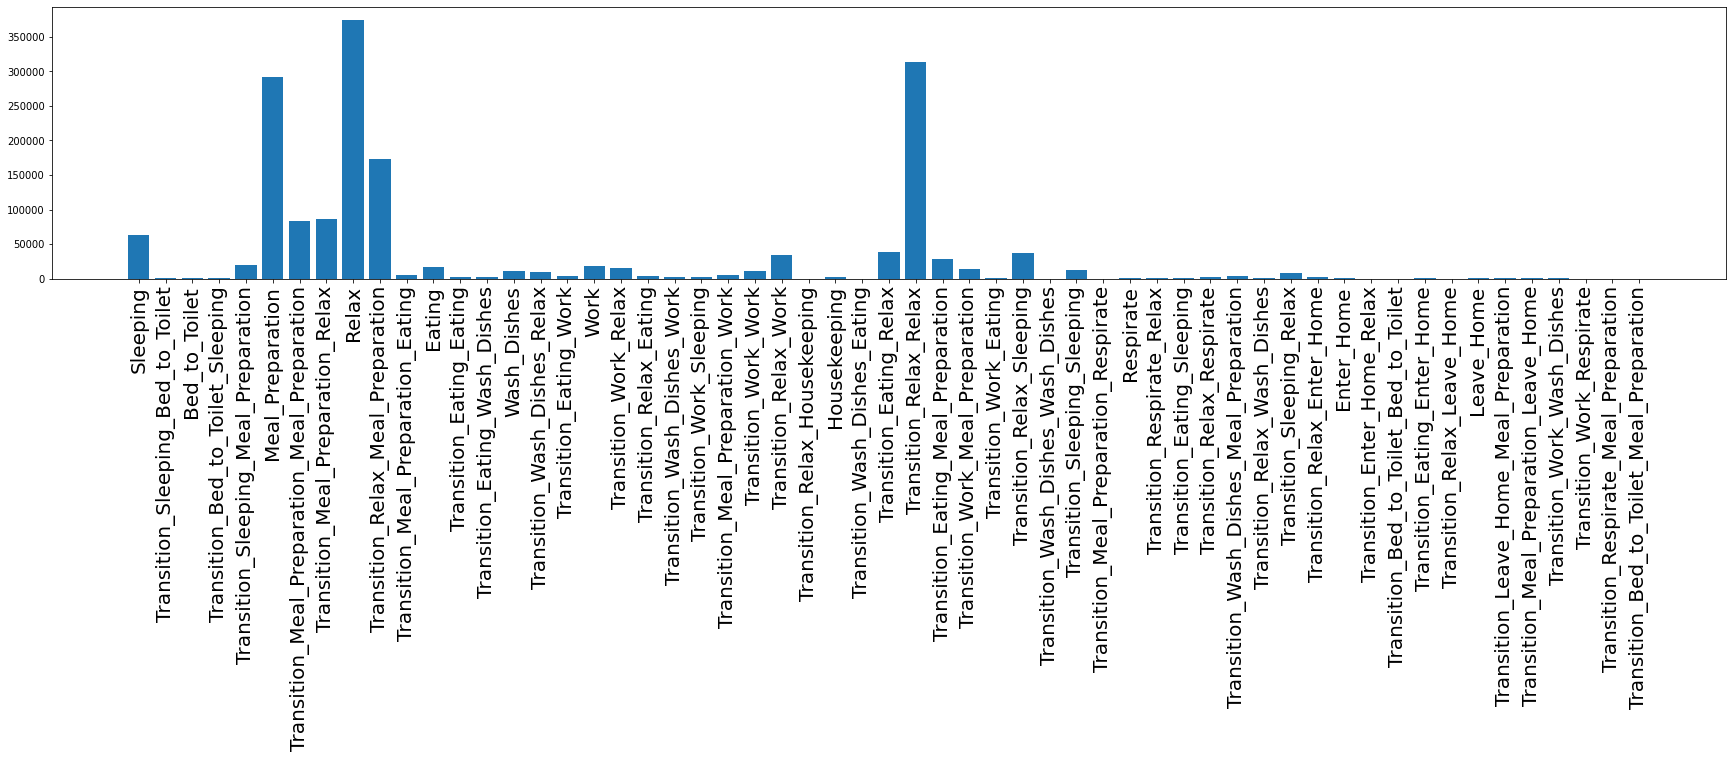

In [40]:
fig = plt.figure(figsize=(30,5))
plt.xticks(rotation='vertical', fontsize=20)
plt.bar(keys, values)

In [41]:
pca_dataframe = preprocessed_data.drop(columns=['Activities', 'Weekday', 'Seconds', 'Daytime'])
pca_dataframe.head()

,M001,M002,M003,M004,M005,M006,M007,M008,M009,M010,...,M030,D001,D002,D003,D004,T001,T002,T003,T004,T005
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,23.018338,23.018338,23.018338
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,21.000000,23.018338,23.018338
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,21.000000,21.000000,23.018338


In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
stdsc.fit(pca_dataframe)
scaled_dataframe = stdsc.transform(pca_dataframe)
pca = PCA(n_components=3)
pca.fit(scaled_dataframe)

PCA(n_components=3)

In [43]:
scaled_dataframe.shape

(1709857, 39)

In [44]:
pca_transformed = pca.transform(scaled_dataframe)

In [45]:
pca_transformed.shape

(1709857, 3)

In [46]:
pca_transformed.max(), pca_transformed.min(), pca_transformed.mean()

(35.20615188343403, -6.436233415588677, 5.1684186760804866e-17)

In [47]:
pca_transformed[:,0], pca_transformed[:,0]

(array([-0.26749641,  0.09764217, -0.09752846, ...,  1.09491357,
         1.15918473,  1.09491357]),
 array([-0.26749641,  0.09764217, -0.09752846, ...,  1.09491357,
         1.15918473,  1.09491357]))

In [48]:
color_pca = []
for i in preprocessed_data['Activities']:
    color_pca.append(labels_dict[i])
color_pca

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


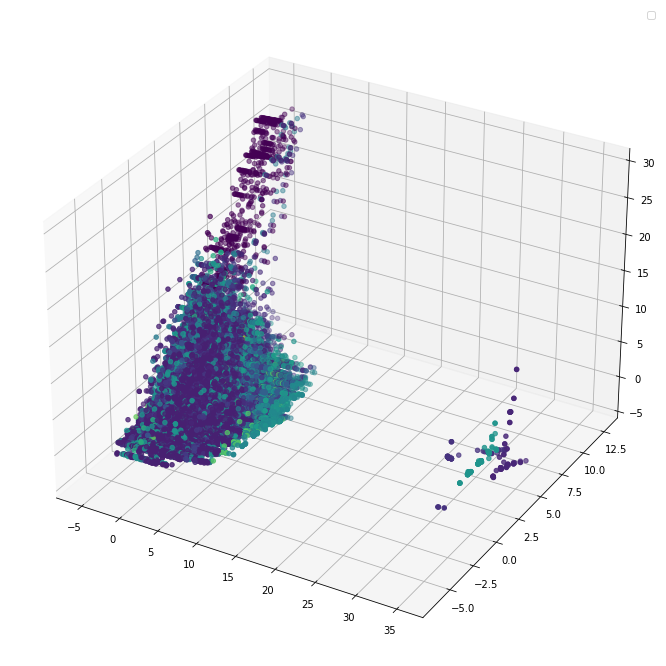

In [49]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_transformed[:,0], pca_transformed[:,1], pca_transformed[:,2], c=color_pca)
ax.legend()
plt.show()

In [50]:
pca2d = PCA(n_components=2)
pca2_data = pca2d.fit_transform(scaled_dataframe)

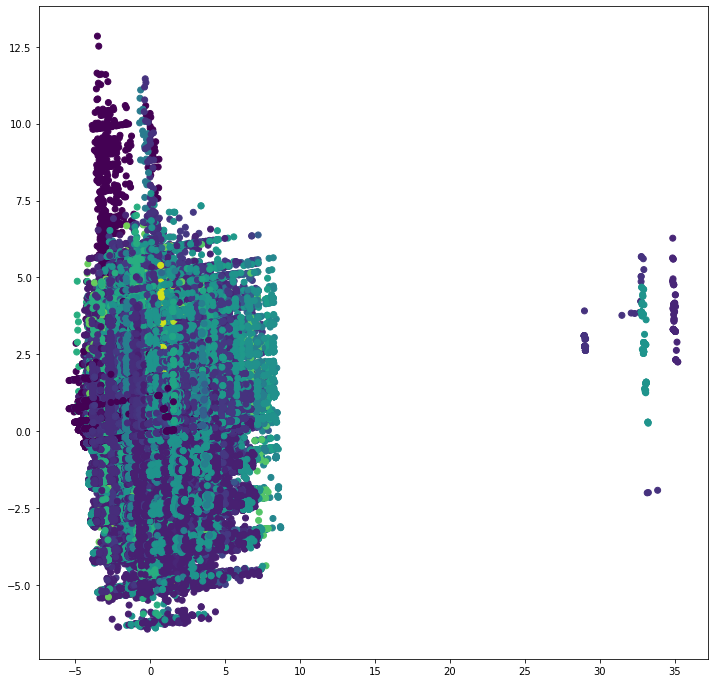

In [51]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
ax.scatter(pca2_data[:,0], pca2_data[:,1], c=color_pca)
plt.show()

In [52]:
count_daytime = Counter(preprocessed_data['Daytime'])
keys_daytime = []
values_daytime = []
for key, value in count_daytime.items():
    keys_daytime.append(key)
    values_daytime.append(value)
    

In [53]:
keys_daytime

['Morning_Night', 'Morning_Day', 'Afternoon', 'Evening']

In [54]:
values_daytime


[143221, 600691, 629992, 335953]

Text(0.5, 1.0, 'Activity during all 4 periods of the day')

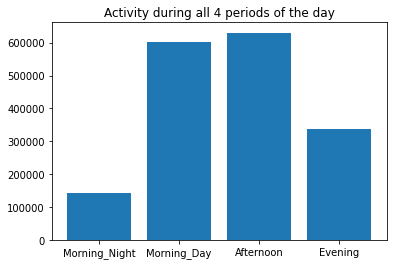

In [55]:
plt.bar(keys_daytime, values_daytime)
plt.title('Activity during all 4 periods of the day')

In [56]:
count_weekday = Counter(preprocessed_data['Weekday'])
keys_weekday = []
values_weekday = []
for key, value in count_weekday.items():
    keys_weekday.append(key)
    values_weekday.append(value)
    

In [57]:
preprocessed_data.head()

,Activities,Weekday,Seconds,Daytime,M001,M002,M003,M004,M005,M006,...,M030,D001,D002,D003,D004,T001,T002,T003,T004,T005
0,Sleeping,3,230,Morning_Night,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
1,Sleeping,3,237,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
2,Sleeping,3,908,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,23.018338,23.018338,23.018338
3,Sleeping,3,1819,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,21.000000,23.018338,23.018338
4,Sleeping,3,1819,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,21.000000,21.000000,23.018338


[Text(3, 0, 'Monday'),
 Text(4, 0, 'Tuesday'),
 Text(5, 0, 'Wednesday'),
 Text(6, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(1, 0, 'Saturday'),
 Text(2, 0, 'Sunday')]

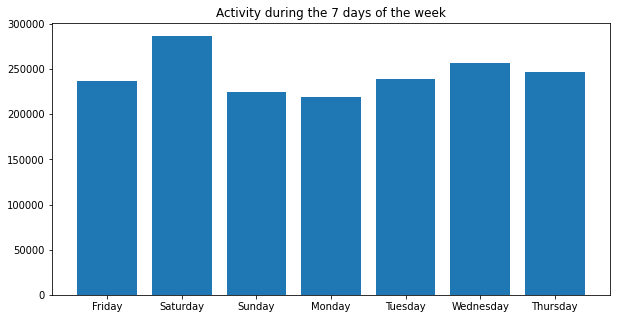

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(keys_weekday, values_weekday)
plt.title('Activity during the 7 days of the week')
ax.set_xticks(keys_weekday)
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

PREPARE DATA FOR MACHINE LEARNING / DEEP LEARNING MODELS
DUMMY VARIABLES + GET KEY BASED LABELS

In [59]:
labels = []
for a in preprocessed_data['Activities']:
    labels.append(labels_dict[a])
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [60]:
X = preprocessed_data.drop(columns=['Activities'])
X.head()

,Weekday,Seconds,Daytime,M001,M002,M003,M004,M005,M006,M007,...,M030,D001,D002,D003,D004,T001,T002,T003,T004,T005
0,3,230,Morning_Night,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
1,3,237,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,23.018338,23.018338,23.018338,23.018338
2,3,908,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,23.018338,23.018338,23.018338
3,3,1819,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,21.000000,23.018338,23.018338
4,3,1819,Morning_Night,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.018338,21.500000,21.000000,21.000000,23.018338


In [61]:
X_dummied = pd.get_dummies(X)

In [62]:
X_dummied

,Weekday,Seconds,M001,M002,M003,M004,M005,M006,M007,M008,...,D004,T001,T002,T003,T004,T005,Daytime_Afternoon,Daytime_Evening,Daytime_Morning_Day,Daytime_Morning_Night
0,3,230,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.018338,23.018338,23.018338,23.018338,23.018338,0,0,0,1
1,3,237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.018338,23.018338,23.018338,23.018338,23.018338,0,0,0,1
2,3,908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.018338,21.500000,23.018338,23.018338,23.018338,0,0,0,1
3,3,1819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.018338,21.500000,21.000000,23.018338,23.018338,0,0,0,1
4,3,1819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.018338,21.500000,21.000000,21.000000,23.018338,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709852,5,85379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,24.000000,25.500000,24.500000,24.500000,23.500000,0,1,0,0
1709853,5,85682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.500000,25.500000,24.500000,24.500000,23.500000,0,1,0,0
1709854,5,85682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.500000,25.000000,24.500000,24.500000,23.500000,0,1,0,0
1709855,5,85986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.500000,25.500000,24.500000,24.500000,23.500000,0,1,0,0


In [63]:
scaler = StandardScaler()
X_dummied_scaled = scaler.fit_transform(X_dummied)

In [64]:
X_dummied_scaled

array([[ 0.00546968, -2.63575159, -0.08626786, ..., -0.49449405,
        -0.73591438,  3.30735414],
       [ 0.00546968, -2.63538219, -0.08626786, ..., -0.49449405,
        -0.73591438,  3.30735414],
       [ 0.00546968, -2.59997259, -0.08626786, ..., -0.49449405,
        -0.73591438,  3.30735414],
       ...,
       [ 0.99466784,  1.87366874, -0.08626786, ...,  2.02226904,
        -0.73591438, -0.30235649],
       [ 0.99466784,  1.88971124, -0.08626786, ...,  2.02226904,
        -0.73591438, -0.30235649],
       [ 0.99466784,  1.90575374, -0.08626786, ...,  2.02226904,
        -0.73591438, -0.30235649]])

In [65]:
X_dummied_scaled.shape

(1709857, 45)

In [66]:
labels = np.array(labels).reshape((-1, 1))

In [67]:
X_dummied_scaled.shape, labels.shape

((1709857, 45), (1709857, 1))

In [68]:
from numpy import savetxt
savetxt('X.csv', X_dummied_scaled, delimiter=',')

In [69]:
from numpy import save
save('X', X_dummied_scaled)

In [70]:
savetxt('y.csv', labels, delimiter=',')
save('y', labels)

In [71]:
### Data exploration

In [79]:
def change_Booleans(data):
    n= len(data)
    count = 0
    for i in range(n-1):
        if data[i] != data[i+1] and data[i+1] == True :
            count += 1
        
    return count

def count_weekday(data):
    weekdays = np.zeros(7)
    for i in range(7):
        output = preprocessed_data['Weekday']== i
        weekdays[i]= change_Booleans(output)
    return weekdays

data = preprocessed_data
data.at[0, "Weekday"] = 10 # let the first value always become False
data = data['Weekday']
print(data)
print(preprocessed_data['Weekday']==3)
#get the number of weekdays occur in the dataset
weekdays =count_weekday(data)
print(weekdays)
#get output of [31. 31. 31. 32. 32. 32. 31.]



0          10
1           3
2           3
3           3
4           3
           ..
1709852     5
1709853     5
1709854     5
1709855     5
1709856     5
Name: Weekday, Length: 1709857, dtype: int64
0          False
1           True
2           True
3           True
4           True
           ...  
1709852    False
1709853    False
1709854    False
1709855    False
1709856    False
Name: Weekday, Length: 1709857, dtype: bool
[31. 31. 31. 32. 32. 32. 31.]


In [73]:
"""dict_from_list = dict(zip(keys_weekday, values_weekday))
print(dict_from_list)
import collections
a=collections.OrderedDict(sorted(dict_from_list.items()))
def average_weekdays(a,b):
    for i in range(7):
        a[i]=a[i]/b[i]
    return a

output = average_weekdays(a,weekdays)
print(a)
"""

{3: 219617, 4: 238545, 5: 256765, 6: 246328, 0: 237283, 1: 286800, 2: 224519}


NameError: name 'weekdays' is not defined

NameError: name 'output' is not defined

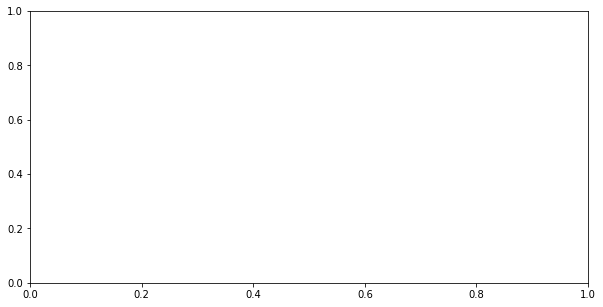

In [74]:
new_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(new_keys, output.values())
plt.title('Activity during the 7 days of the week')
ax.set_xticks(keys_weekday)

In [75]:
def count_days(data):
    data_second = data['Seconds']
    data_Activities = data['Activities']
    day_list = 0
    sleeptime_list = []
    n= len(data)
    day_count = 0
    sleep_time=0
    day_change_state = False
    
    for i in range(n-1):
        if data_Activities[i] == data_Activities[i+1] and data_Activities[i] == 'Sleeping':
            if data_second[i] > data_second[i+1] :
                sleep_time += (86400 - data_second[i])
            elif day_change_state == True:
                sleep_time += data_second[i]
            else :
                sleep_time += (data_second[i+1] - data_second[i])
        day_change_state = False
        if data_second[i] > data_second[i+1] :
            day_count += 1
            day_change_state = True
            sleeptime_list.append(sleep_time)
            sleep_time=0
        
    return day_count , sleeptime_list
day_count , sleeptime_list = count_days(preprocessed_data)

In [80]:
new_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
new_keys[0]= preprocessed_data.loc[preprocessed_data['Weekday'] ==0]

def get_data_weekdays(data , list_weekdays):
    for i in range(7):
        list_weekdays[i] = data.loc[data['Weekday'] == i ]
    return list_weekdays

def get_daytime(weekdays_data ):
    values_weekdays_daytime = []
    for i in range(7):
        count_daytime = Counter(weekdays_data[i]['Daytime'])
        keys_daytime= []
        values_daytime= []
        for key, value in count_daytime.items():
            keys_daytime.append(key)
            values_daytime.append(value)
            
        values_weekdays_daytime.append(values_daytime)
    return values_weekdays_daytime
    
weekdays_data = get_data_weekdays(preprocessed_data, new_keys )

count_daytime = Counter(weekdays_data[0]['Daytime'])
keys_daytime0= []
values_daytime0= []
for key, value in count_daytime.items():
    keys_daytime0.append(key)
    values_daytime0.append(value)

print(get_daytime(weekdays_data ))
test = get_daytime(weekdays_data )
test = average_weekdays(test , weekdays)


# [[0 3]
#  [1 4]
#  [2 5]]
# <class 'numpy.ndarray'>

l_2d_t = np.array(test).T.tolist()
print(l_2d_t)
print(np.add(l_2d_t[0],l_2d_t[1]))


[[16672, 97166, 80217, 43228], [19453, 79741, 132991, 54615], [17831, 85999, 78257, 42432], [23599, 76241, 76856, 42920], [20601, 87995, 78135, 51814], [20793, 86613, 98764, 50595], [24271, 86936, 84772, 50349]]
[[537.8064516129032, 627.516129032258, 575.1935483870968, 737.46875, 643.78125, 649.78125, 782.9354838709677], [3134.3870967741937, 2572.2903225806454, 2774.1612903225805, 2382.53125, 2749.84375, 2706.65625, 2804.3870967741937], [2587.6451612903224, 4290.032258064516, 2524.4193548387098, 2401.75, 2441.71875, 3086.375, 2734.5806451612902], [1394.4516129032259, 1761.774193548387, 1368.774193548387, 1341.25, 1619.1875, 1581.09375, 1624.1612903225807]]
[3672.19354839 3199.80645161 3349.35483871 3120.         3393.625
 3356.4375     3587.32258065]


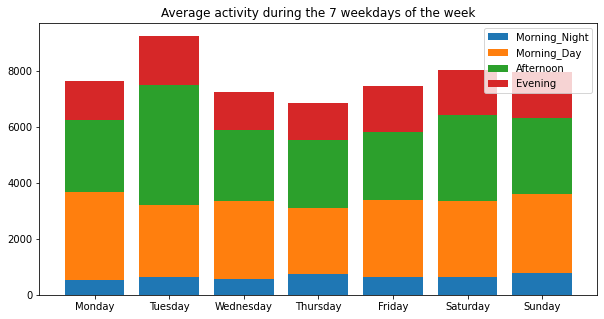

In [81]:
new_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, ax = plt.subplots(figsize=(10, 5))
#ax.bar(new_keys, output.values())

ax.bar(new_keys, l_2d_t[0]   , label=keys_daytime0[0])
ax.bar(new_keys, l_2d_t[1]  , bottom=l_2d_t[0] , label=keys_daytime0[1])
ax.bar(new_keys, l_2d_t[2]  , bottom= np.add(l_2d_t[0] , l_2d_t[1]) , label=keys_daytime0[2])
ax.bar(new_keys, l_2d_t[3]  , bottom= np.add(np.add(l_2d_t[0] , l_2d_t[1]) , l_2d_t[2] ) , label=keys_daytime0[3])
plt.title('Average activity during the 7 weekdays of the week')

ax.set_xticks(keys_weekday)
ax.legend()
plt.show()

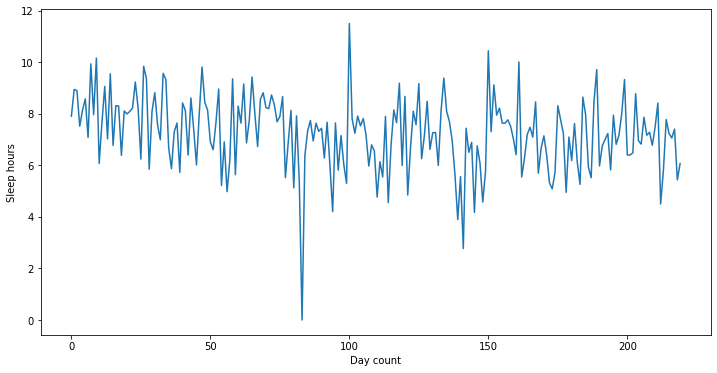

In [82]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()

x = range(day_count)
ax.set_ylabel('Sleep hours')
ax.set_xlabel('Day count')
ax.plot(x, np.divide(sleeptime_list,3600));


In [ ]:
## Header 1

In [ ]:

def activities_days(data ,activity_keys):
    activities_time_per_day = []
    k= len(activity_keys)
    n= len(data)
    data_second = data['Seconds']
    data_Activities = data['Activities']
    for a in range(k):
        Activities_time_list = []
        time=0
        day_count = 0
        day_change_state = False
        for i in range(n-1):
            if data_Activities[i] == data_Activities[i+1] and data_Activities[i] == activity_keys[a]:
                if data_second[i] > data_second[i+1] :
                    time += (86400 - data_second[i])
                elif day_change_state == True:
                    time += data_second[i]
                else :
                    time += (data_second[i+1] - data_second[i])
            day_change_state = False
            if data_second[i] > data_second[i+1] :
                day_count += 1
                day_change_state = True
                Activities_time_list.append(time)
                time=0
        activities_time_per_day.append(Activities_time_list)
    return activities_time_per_day


activities_time_per_day = activities_days(preprocessed_data ,keys)    


## Showing the average daytime spend on each activity 

In [ ]:
print(keys)
print(sleeptime_list)
activities_time_per_day_in_hour = np.divide(activities_time_per_day,3600)
df2 = pd.DataFrame(np.array(activities_time_per_day_in_hour),
                   index=keys).T
df2 = df2.rename_axis('day count')
#save to csv
df2.to_csv('activities_daytime_spend.csv')
df2.describe(include='all').drop(index=('count'))
